# Setup

In [1]:
import scanpy as sc
import numpy as np
import re
import os
import pandas as pd
import seaborn as sb
import matplotlib
import scipy.sparse as sp
from scipy.sparse import issparse
import anndata2ri

import matplotlib as mpl
from scipy import stats as scistats
import matplotlib.pyplot as pl
import scanpy.external as sce
from matplotlib import colors
import bbknn
from pathlib import Path
from ipywidgets import interactive

sc._settings.ScanpyConfig.n_jobs=8

pl.rcParams['pdf.fonttype'] = 'truetype'
sc.set_figure_params(vector_friendly=False,dpi_save=300,transparent=True)
pl.rcParams['lines.linewidth'] = 0.1
sc.set_figure_params(color_map='viridis')
colorsComb = np.vstack([pl.cm.Reds(np.linspace(0, 1, 10)), pl.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

import muon as mu
from muon import prot as pt

%matplotlib inline
import panel as pn
#pn.extension(sizing_mode="stretch_width", comms='colab')
pn.extension( comms='colab')


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-d30vudla because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


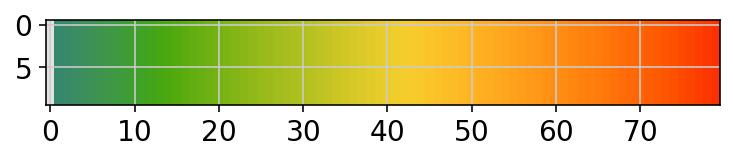

In [2]:
import colorcet as cc

xs, _ = np.meshgrid(np.linspace(0, 1, 80), np.linspace(0, 1, 10))
colorsComb = np.vstack([pl.cm.Greys_r(np.linspace(0.8,0.1, 1)), cc.cm.rainbow_bgyr_35_85_c72(np.linspace(0.2,1, 100))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
pl.imshow(xs, cmap=mymap);  # use tab completion to choose

In [3]:
# add extra code to the path
import sys
sys.path.append('content/sctoolkit/sctoolkit/')
from proportions import *

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [4]:
%load_ext watermark
%watermark
%watermark --iversions -v -m -p numpy,scipy,sklearn,anndata,scanpy,muon,anndata2ri,rpy2

Last updated: 2022-07-13T11:56:02.025762-07:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.71.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

numpy     : 1.21.6
scipy     : 1.8.0
sklearn   : 0.0
anndata   : 0.7.8
scanpy    : 1.9.1
muon      : 0.1.2
anndata2ri: 1.0.6
rpy2      : 3.5.1

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.71.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit

numpy     : 1.21.6
anndata2ri: 1.0.6
colorcet  : 3.0.0
seaborn   : 0.11.2
matplotlib: 3.5.2
pandas    : 1.2.5
muon      : 0.1.2
re        : 2.2.1
scipy     : 1.8.0
panel     : 0.13.1
bbknn     : 1.5.1
sys       : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]


# Download PBMC data from 10X

In [5]:
data_dir = '../../public-data/3_multiomics/data/'
! pwd

/projects/ps-yeolab3/bay001/codebase/cshl_2022/3_multiomics/notebooks


# Setup WD

In [6]:
#Change XXX to sample name
#folder='/content/'
samplename='PBMC_granulocyte_sorted'
random_state=42

import os

if not os.path.exists('./figures/'):
    os.makedirs('./figures/')

# import data as H5AD

In [7]:
mdata = mu.read_10x_h5(data_dir + "/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5")
mdata.var_names_make_unique()
mdata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from ../../public-data/3_multiomics/data//pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.9/site-packages/mudata/_core/mudata.py:405: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [8]:
mdata.obs['sample']=[samplename]*mdata.n_obs
mdata.obs['group']=[samplename]*mdata.n_obs

In [9]:
rna = mdata.mod['rna']

rna.obs['sample']=[samplename]*rna.n_obs
rna.obs['group']=[samplename]*rna.n_obs
rna

AnnData object with n_obs × n_vars = 11909 × 36601
    obs: 'sample', 'group'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [10]:
sc.pp.filter_genes(rna, min_cells=10)
rna

AnnData object with n_obs × n_vars = 11909 × 22020
    obs: 'sample', 'group'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells'

In [11]:
# Quality control - calculate QC covariates
rna.obs['n_counts'] = rna.X.sum(1)
rna.obs['log_counts'] = np.log(rna.obs['n_counts'])
rna.obs['n_genes'] = (rna.X > 0).sum(1)

# compute qc metrics

rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
rna.var['rb'] = rna.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal proteins as 'rb'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(rna, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

rna

AnnData object with n_obs × n_vars = 11909 × 22020
    obs: 'sample', 'group', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Filter doublets with scrublet

In [ ]:
sce.pp.scrublet(rna,
    adata_sim = None,
    sim_doublet_ratio= 2.0,
    expected_doublet_rate = 0.05,
    stdev_doublet_rate = 0.02,
    synthetic_doublet_umi_subsampling= 1.0,
    knn_dist_metric = 'euclidean',
    normalize_variance= True,
    log_transform= False,
    mean_center= True,
    n_prin_comps= 30,
    use_approx_neighbors= True,
    get_doublet_neighbor_parents= False,
    n_neighbors = None,
    threshold = None,
    verbose = True,
    copy= False,
random_state= 0,)

/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.


In [ ]:
sb.set_context('paper')
savefig=samplename + '_7_QC_doublets.pdf'
sce.pl.scrublet_score_distribution(rna,save=savefig)

# Helper plots for determining gene and count threshold values

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(rna.obs['n_counts'], kde=False, ax=ax1,)
ax2_dict =  sb.histplot(rna.obs['n_counts'][rna.obs['n_counts']<1000], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(rna.obs['n_counts'][rna.obs['n_counts']<5000], kde=False, bins=60, ax=ax3,)
ax4_dict = sb.histplot(rna.obs['n_counts'][rna.obs['n_counts']>10000], kde=False, bins=60, ax=ax4, )
savefig='figures/'+samplename + '_1_QC_counts_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sb.histplot(rna.obs['n_genes'], kde=False, bins=60, ax=ax1,)
ax2_dict =  sb.histplot(rna.obs['n_genes'][rna.obs['n_genes']<500], kde=False, bins=60, ax=ax2,)
ax3_dict =  sb.histplot(rna.obs['n_genes'][rna.obs['n_genes']<1000], kde=False, bins=60, ax=ax3,)
savefig='figures/'+samplename + '_2_QC_gene_filtering.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

In [ ]:
# plot percentage of mitochondtial genes versus count depth and n_genes
sb.set_context('paper')
pl.rcParams['figure.figsize']=(5,5) #rescale figures
savefig=samplename + '_4_QC_saturationplot.pdf'
sc.pl.scatter(rna, x='total_counts', y='n_genes', color='pct_counts_mt',save=savefig)

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), gridspec_kw={'wspace':0.2})

ax1_dict = sc.pl.violin(rna, 'n_counts', groupby='group', size=0.5, log=True, cut=0, ax=ax1, show=False)
ax2_dict =  sc.pl.violin(rna, 'n_genes', groupby='group', size=0.5, log=True, cut=0, ax=ax2, show=False)
ax3_dict = sc.pl.violin(rna, 'pct_counts_mt', groupby='group',size=0.5, ax=ax3, show=False,)
savefig='figures/'+samplename + '_5_QC_violin_plots.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

In [ ]:
sb.set_context('paper')
pl.rcParams['lines.linewidth'] = 0.1
savefig='_'+samplename + '_6_QC_highest_expr_genes.pdf'
sc.pl.highest_expr_genes(rna, n_top=20,save=savefig,)

In [ ]:
print(rna.obs['group'].value_counts())

In [ ]:
rna.obs['n_counts'].sum()/rna.obs['group'].value_counts()

In [ ]:
rna.obs['n_counts'].sum()

In [ ]:
def h(counts=400, genes=400,mito=15):
    conditions = [(rna.obs['predicted_doublet'] == True),(rna.obs['n_genes_by_counts'] < counts),(rna.obs['n_genes'] < genes),(rna.obs['pct_counts_mt'] >mito),(rna.obs['pct_counts_mt'] <= mito) & (rna.obs['n_genes_by_counts'] >= counts) & (rna.obs['n_genes'] >= genes)& (rna.obs['predicted_doublet'] != True)]
    values = ['Doublet', 'Low_nFeature', 'Low_ngenes','High_MT', 'Passing']
    rna.obs['QC'] = np.select(conditions, values)
    rna.obs['QC'] = rna.obs['QC'].astype('category')

    new_df1=pd.DataFrame(rna.obs['QC'].value_counts()).reset_index()
    p=sb.barplot(x='index',y='QC',data=new_df1,color='sandybrown')
    show_values(p)


interactive_plot = interactive(h, counts=(0, 2000,20), genes=(0, 2000,20), mito=(0, 100, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [ ]:
rna.obs['QC'].value_counts()

## Plot QC for cells that pass tentative thresholds

In [ ]:

sb.set_context('paper')


fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharey=False)
rna.obs['n_genes']

sb.histplot( rna[rna.obs['QC'] == 'Passing'].obs['n_genes'], ax=ax1, kde=True, bins=100)
sb.histplot( rna[rna.obs['QC'] == 'Pass'].obs['n_counts'], ax=ax2, kde=True, bins=100)
sb.histplot(rna[rna.obs['QC'] == 'Pass'].obs['pct_counts_mt'], ax=ax3, kde=True, bins=100)

ax1.title.set_text('n_genes')
ax2.title.set_text('n_counts')
ax3.title.set_text('mt_pct')

fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()
savefig='figures/'+samplename + '_3_QC_filtering_postfilter.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

# Nomalization

In [ ]:
rna.layers["raw"] = rna.X 
rna.raw=rna
rna.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(rna, inplace=False)["X"])

In [ ]:
sc.experimental.pp.recipe_pearson_residuals(rna,n_top_genes=3000,n_comps=100,random_state=42,inplace=True)
rna.layers["normalized"]=rna.X

rna

In [ ]:
markers = ["IL7R","LYZ","CD14","MS4A1","CD8A","GNLY","NKG7","FCGR3A","MS4A7","FCER1A","CST3","PPBP",]
hvgs = adata.var["highly_variable"]
fig, ax = plt.subplots(figsize=(6, 6))
pl.scatter(
        adata.var["mean_counts"], adata.var["residual_variances"], s=3, edgecolor="none"
    )
pl.scatter(
        adata.var["mean_counts"][hvgs],
        adata.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
    )
pl.scatter(
        adata.var["mean_counts"][np.isin(adata.var_names, markers)],
        adata.var["residual_variances"][np.isin(adata.var_names, markers)],
        c="k",
        label="known marker genes",
        s=10,
        edgecolor="none",
    )
ax.set_xscale("log")
ax.set_xlabel("mean expression")
ax.set_yscale("log")
ax.set_ylabel("residual variance")
ax.set_title(samplename)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# cellcycle score

In [ ]:
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM7','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1',
           'UHRF1','CENPU','HELLS','RFC2','POLR1B','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7',
           'POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
           'USP1','CLSPN','POLA1','CHAF1B','MRPL36','E2F8']
g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B',
             'MKI67','TMPO','CENPF','TACC3','PIMREG','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1',
             'KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','JPT1','CDC20','TTK','CDC25C',
             'KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1',
             'ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
cell_cycle_genes = s_genes + g2m_genes
display(len(s_genes))
display(len(g2m_genes))
display(len(cell_cycle_genes))

In [ ]:
cell_cycle_genes = [x for x in cell_cycle_genes if x in rna.var_names]
len(cell_cycle_genes)

In [ ]:
sc.tl.score_genes_cell_cycle(rna, s_genes=s_genes, g2m_genes=g2m_genes)

In [ ]:
adata_cc_genes = rna[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

# PCA

In [ ]:
#sc.pp.scale(rna,max_value=10)

In [ ]:
#sc.pp.pca(rna, n_comps = 100, use_highly_variable =False, svd_solver = "arpack")
sc.pl.pca_variance_ratio(rna, n_pcs = 100,log=True)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(rna, n_pcs=30,n_neighbors=10,random_state=42)
#bbknn.bbknn(rna,batch_key = "donnor", neighbors_within_batch =10, n_pcs = 50)
#Save to figures (not sample specific folder)
genes_to_plot = ['n_genes','n_counts','log_counts','pct_counts_mt','doublet_score']
#sc.tl.tsne(rna, n_jobs=8,use_rep='X', perplexity=30) 
sc.tl.umap(rna,random_state=42)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(rna, color = genes_to_plot,ncols=2,wspace=0.25, save=savefig)

In [ ]:
rna

In [ ]:
rna = rna[rna.obs['QC'] == 'Passing']
rna

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(rna, color = genes_to_plot,ncols=2,layer='counts',save=savefig)

# Re-analyse the data only with cells passing QC

In [ ]:
rna.X=rna.layers['raw']

In [ ]:
#HVG
sc.experimental.pp.highly_variable_genes(rna, flavor="pearson_residuals", n_top_genes=3000)

In [ ]:
# Nomalization
sc.experimental.pp.normalize_pearson_residuals(rna,inplace=True)
rna.layers["normalized"]=rna.X

In [ ]:
#PCA
sc.pp.pca(rna, n_comps=30,random_state=42)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
sc.pp.neighbors(rna, n_pcs=30,n_neighbors=10,random_state=42)

genes_to_plot = ['n_genes','log_counts','pct_counts_mt']

sc.tl.umap(rna,random_state=42)
savefig=samplename+"_4_QC_doublets_vst_mito.pdf"
sc.pl.umap(rna,wspace=0.25, color = genes_to_plot,ncols=2,save=savefig)

In [ ]:
%%capture
sc.tl.leiden(rna,random_state=random_state,resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(rna,random_state=random_state,resolution=1, key_added='leiden_r1')
sc.tl.leiden(rna,random_state=random_state, resolution=0.8, key_added='leiden_r0.8')
sc.tl.leiden(rna,random_state=random_state, resolution=0.5, key_added='leiden_r0.5')
sc.tl.leiden(rna,random_state=random_state, resolution=0.4, key_added='leiden_r0.4')
sc.tl.leiden(rna,random_state=random_state, resolution=0.3, key_added='leiden_r0.3')
sc.tl.leiden(rna,random_state=random_state, resolution=0.2, key_added='leiden_r0.2')

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(rna,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_lores_vst.pdf"
sc.pl.umap(rna, color=['leiden_r0.2','leiden_r0.3','leiden_r0.4'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
#sc.tl.leiden(rna,random_state=random_state, resolution = 0.5)
savefig=samplename+"_clustering_hires_vst.pdf"
sc.pl.umap(rna, color=['leiden_r0.5','leiden_r0.8','leiden_r1.5'], legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

In [ ]:
sc.tl.paga(rna,groups='leiden_r0.5')
sc.pl.paga(rna, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(rna, init_pos='paga')

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(5,5)
savefig=samplename+"_5_clustering_vst_lowres.pdf"
sc.pl.umap(rna, color=['leiden_r0.5','pct_counts_mt','pct_counts_rb','S_score','G2M_score','doublet_score'],ncols=3, legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',frameon=False,save=savefig)

# Marker genes

In [ ]:
#method : {‘logreg’, ‘t-test’, ‘wilcoxon’, ‘t-test_overestim_var’} | None (default: None)
sc.tl.rank_genes_groups(rna, 'leiden_r0.5', method='t-test',n_genes=rna.shape[1])
markers=pd.DataFrame(rna.uns['rank_genes_groups']['names']).head(20)
markers

In [ ]:
sb.set_context('paper')
pl.rcParams['figure.figsize']=(4,4) #rescale figures
savefig=samplename+"_10_markers_1.pdf"
sc.pl.umap(adata=rna, color=['CD14','FCGR3A','FCER1A','JCHAIN','LILRA4','MS4A1','CD8B','CD4','CCR7','IL32','NKG7','FOXP3','IKZF2'],color_map=mymap,vmin='p20', vmax='p99.9',ncols=4,
           legend_loc='on data',legend_fontoutline=3, legend_fontweight='normal',use_raw=False,layer="sqrt_norm", save=savefig)

# Annotation

In [ ]:
rna.obs['annotated'] = rna.obs['leiden_r0.5'].cat.add_categories([ "CD4+ memory T", "CD8+ naïve T", "CD4+ naïve T", "CD8+ activated T", "NK",  "MAIT",'Tregs',
                                                                  "memory B", "naïve B","CD14 mono", "intermediate mono", "CD16 mono","mDC", "pDC",])
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['3'])] = 'CD4+ memory T'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['0','14','13'])] = 'CD4+ naïve T'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['1'])] = 'CD8+ naïve T'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['10'])] = 'Tregs'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['11'])] = 'MAIT'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['6',])] = 'CD8+ activated T'
#rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['7'])] = 'memory B'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['5'])] = 'naïve B'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['7'])] = 'NK'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['2'])] = 'CD14 mono'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['4'])] = 'intermediate mono'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['8'])] = 'CD16 mono'
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['9'])] = "mDC"
rna.obs['annotated'][np.in1d(rna.obs['annotated'], ['12'])] = "pDC"

rna.obs['annotated'] = rna.obs['annotated'].cat.remove_unused_categories()

In [ ]:
sb.set_context('talk')
pl.rcParams['figure.figsize']=(7,7)
#sc.tl.leiden(adata,random_state=random_state, resolution = 0.5)
savefig=samplename+"_annotated_hires_annotated.pdf"
sc.pl.umap(rna, color=['annotated'], legend_loc='on data',cmap=mymap,legend_fontoutline=3,vmax='p99.9',legend_fontsize='small', legend_fontweight='normal',frameon=False,save=savefig)

#sample composition

In [ ]:
 fig=plot_proportion_barplot_with_ncells(
    rna,
    'group',
    fill='annotated', 
    fill_breakdown=None,
    yaxis_label=None,
    fill_label='annotated',
    percent_limit=1., 
    show_percent=True,
    height_scale=1., 
    width_scale=1.,
    legend_position=(-0, 0.5),
    normalize_by=None,)
fig.savefig('cell_composition_by_FOV.pdf', dpi=300, bbox_inches='tight')